# ASL Alphabet Classifier Test


### The goal of this Sign2 variation is to experiment with using Mixup Regularization
(See "mixup: Beyond Empirical Risk Minimization" - Hongyi Zhang, Moustapha Cisse, Yann N. Dauphin, David Lopez-Pazj, 2018;  https://arxiv.org/abs/1710.09412) 

<br>

#### Datasource: 
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>

<br>

This is a prototype, playing with FastAI using Resnet34 to classify American Sign Language alphabet.  It's basically Notebook #2 from the MOOC on a "clean" dataset.  We get great results ... but the data is really contrived.  It's highly likely the model will overfit, however it's a good test of the library.
<br>
<br>
### Data Wrangling info
The data has been reorganized to put sign images in labelled directories, making it easy to import and sort.
We use 2 main data directories and concatenate them together.  the 2nd dataset consists of personally captured images, created using the same notebook that does inference.  We capture every frame of a video and automatically place them in the chosen directory.  The notebook will create the main directory and the label-directory if they don't exist.

<img src="../docs/images/2021-01-13_00-57.png"><br>

<br>
<br>
<HR/>
<br>
<br>

## Run Notes

### SUPER PREPROCESSED

* data: 800 external , 300 frank, 300 crazy processed
* augmentation True
* ~~Label Smoothing~~  Cross-Entropy Loss
* pretrained = false
* bilinear


In [1]:
import warnings
warnings.filterwarnings('ignore')  # or 'once'  

In [2]:
import sys
sys.path.append('utils')

import pyforest

from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import gc
from nn_utils_eff import *
from augmentation import *



USES_TIMM = True
USES_GCHKPT = True
ARCH = 'tf_efficientnet_b4_ns'   # xresnet50 # resnet101

CHOSEN_SAMPLE_SIZE = 1100 # 2500  # use this to control per-category sample sizes # 1000
TEST_SET_SIZE = 200  # number of images per category to put in the test set

remove_from_sample = {
#         'A': 0.5,
#     'B': 0.2,
#     'C': 0.2,
# #     'D': 0.3,
    'E': 0.2,
#     'F': 0.2,
#     'H': 0.3,
# #     'L': 0.7,
#     'M': 0.3,
# #     'N': 0.9,
# #     'O': 0.2,
# #     'Q': 0.75,
# #     'R': 0.4,
#     'U': 0.2
# #     'Y': 0.8 

}  # fractions of original samples to keep

add_to_sample = {  # Use this minimally until we add NEW samples rather than oversampling.
#     'A': 0.2,
#     'B': 0.2,
#     'G': 0.1,
    'I': 0.3,
#     'K': 0.2,
#     'L': 0.2,
#     'N': 0.3,
#     'O': 0.1,
#     'R': 0.3,
#     'S': 0.4,
#     'T': 0.4,
#     'V': 0.1,
#     'W': 0.1,
#     'Y': 0.2
}

FROZEN_EPOCHS = 1  # 1
EPOCHS = 15  # 4
BATCH_SIZE = 48  # 16
RESOLUTION = 380  # 300

PRETRAINED_FLAG = True
GRAD_ACC = 128 # set this to 64 when testing with low data.  Set it to 128, 192 or 256 when using lots of data.
VALID_PERC = 0.2

# data = 'combined3-proc2'
data = 'combined2'

rn_addon = f'_data={data}'
time = datetime.today().strftime("%Y%m%d-%H%M")

RUN_NAME = f'{time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION} {rn_addon}'
print(f"RUN_NAME = '{RUN_NAME}'")


# set this to None if training a new model from scratch
PREV_TRAINED_MODEL_RUN_NAME = None
PREV_TRAINED_MODEL_EPOCH = None




import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
# %matplotlib widget
plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')

%env WANDB_WATCH=false

import wandb
from fastai.callback.wandb import *

wandb.init(project="asl-sign-language-recognition", mode='disabled')
wandb.run.name = RUN_NAME



RUN_NAME = '20210303-1849 - arch=tf_efficientnet_b4_ns - samples=1100 frozen=1 epochs=15 bs=48 res=380 _data=combined2'
env: WANDB_WATCH=false


In [3]:
# path = '../data/external/Training_Set'
path = f'../data/{data}/Training_Set'
# path2 = '../data/frank-ledlights-L'
path2 = None

<br>
<br>

## Check for an available GPU

In [4]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))
print()
# print('CUDA available: '.ljust(24), torch.cuda.is_available())
print(f'fastai version:              {fastai.__version__}')
# print(f'fastcore version:            {fastcore.__version__}')
# print(f'fastbook version:            {fastbook.__version__}')
print(f'cuda version:                {torch.version.cuda}')
print(f'torch version:               {torch.__version__}')
# print(f'python version:              {python_version()}')

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.5
cuda version:                10.1
torch version:               1.7.0


<br>
<br>

### Check for Dataset Imbalance

In [5]:
from string import ascii_uppercase
import numpy as np
import operator




image_files = {}
image_files_qty = {}

# loop through all the characters to build dictionaries of image files and quartity of each category
for c, i in zip(ascii_uppercase, np.arange(len(ascii_uppercase))):
    
    if c == 'J' or c == 'Z': continue  # we don't use these characters
        
    image_files[c] = get_image_files(path + f'/{c}')
    if path2 != None:
        image_files[c] += get_image_files(path2 + f'/{c}')

        
    l = len(image_files[c])
    image_files_qty[c] = l
    
# custom code since we don't use 'Z'
# image_files.pop('J')
# image_files_qty.pop('J')
# image_files.pop('Z')
# image_files_qty.pop('Z')

# Get the character with the largest and smallest number of entries
maxqc = max(image_files_qty, key=image_files_qty.get)
minqc = min(image_files_qty, key=image_files_qty.get)


print()
print(f'Character with the most images:   {maxqc},   with {image_files_qty[maxqc]} images')
print(f'Character with the least images:  {minqc},   with {image_files_qty[minqc]} images')
print(f'Average number of images:         {round(np.mean(list(image_files_qty.values())))}')




Character with the most images:   A,   with 1100 images
Character with the least images:  A,   with 1100 images
Average number of images:         1100


<br>
<br>

<br>
<br>

# Data Preparation and EDA

## Display the number of image files for each category

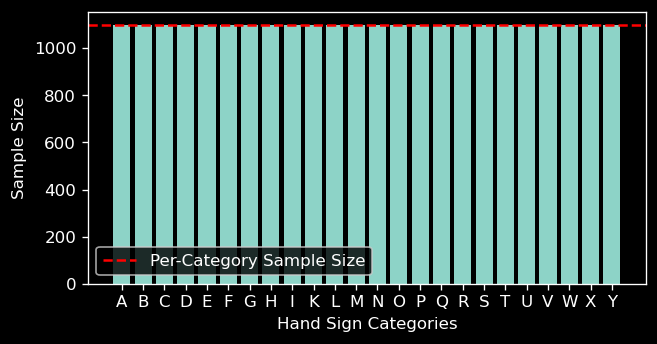

In [6]:
# plt.hist(image_files_qty.items)
plt.figure(figsize=(6,3))
plt.bar(image_files_qty.keys(), image_files_qty.values())
plt.axhline(CHOSEN_SAMPLE_SIZE, ls='--', color='r', label='Per-Category Sample Size')
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')
plt.legend();

<br>
<br>

### Balance the Dataset with Oversampling or Undersampling

Sampled size is modulated by variable `CHOSEN_SAMPLE_SIZE` and will oversample or undersample (or both) depending on the amount of data available vs the chosen sample size

In [7]:
import pandas as pd

maxq = image_files_qty[maxqc] # the quantity of the largest category
minq = image_files_qty[minqc] # the quantity of the smallest category

all_image_files = {}  # holds all the image files in one dataframe
train_image_files = {}
test_image_files = {}

for char, q in iter(image_files_qty.items()):

    image_files_list = list(image_files[char]) 
    
    

    # undersample or over sample as needed
    if CHOSEN_SAMPLE_SIZE > 1:  # neg sample size means the whole set
        if len(image_files_list) >= CHOSEN_SAMPLE_SIZE:
            image_files_list = np.random.choice(image_files_list, CHOSEN_SAMPLE_SIZE, replace=False)  # undersample
        else:
            delta = CHOSEN_SAMPLE_SIZE - len(image_files_list)
            image_files_list.append(np.random.choice(image_files_list, delta, replace=(delta > len(image_files_list))))  # oversample
        
    # siphon off the test set
    test_image_files[char] = np.random.choice(image_files_list, size=TEST_SET_SIZE, replace=False)
    
    train_image_files[char] = list(set(image_files_list) - set(test_image_files[char]))

       
# test_image_files = test_image_files.sample(frac=1, replace=False)  # shuffle - training set is shuffled later

<br>
<br>

### Ensure the Dataset is Balanced

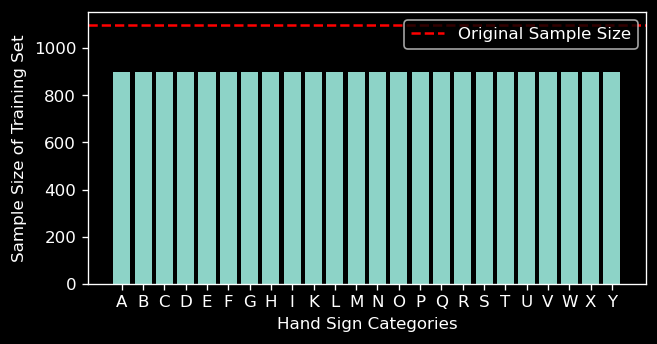

In [8]:
plt.figure(figsize=(6,3))
plt.bar(train_image_files.keys(), [len(l) for l in train_image_files.values()])
# plt.ylim(0, CHOSEN_SAMPLE_SIZE)
plt.axhline(CHOSEN_SAMPLE_SIZE, ls='--', color='r', label='Original Sample Size')
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size of Training Set')
plt.legend();

<br>
<br>

### Check the  Test Set

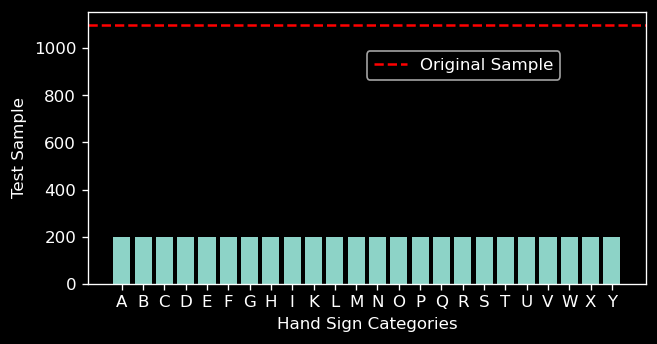

In [9]:
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(test_image_files.keys(), [len(l) for l in test_image_files.values()])
ax.axhline(CHOSEN_SAMPLE_SIZE, ls='--', color='r', label='Original Sample')
plt.xlabel('Hand Sign Categories')
plt.ylabel('Test Sample')
# formatter = ticker.PercentFormatter()
# ax.yaxis.set_major_formatter(formatter)
plt.legend(loc=(0.5,0.75));

<br>
<br>

### Deliberately Adjust the Sample Size of Certain Categories to Fine Tune the Model
Because the data is so easy to overfit and because we see certain categories fitting faster/stronger than others - causing the model to always select those categories... we try to balance that effect by decreasing the number of samples. 

In [10]:
# for key in remove_from_sample:
#     train_image_files[key] = train_image_files[key], (1 - remove_from_sample[key]))
    
# ## @TODO: sample outside the training set rather than oversampling.
# for key in add_to_sample:
#     train_image_files[key] = train_image_files[key].extend(np.random.choice(train_image_files[key], add_to_sample[key]))
    
# #     pd.concat([train_image_files[key],pd.Series(train_image_files[key]).sample(frac=add_to_sample[key])])

<br>
<br>

### Check that the Training Dataset has been Appropriately Altered

In [11]:
# if remove_from_sample != {}:
#     fig, ax = plt.subplots(figsize=(6,3))
#     plt.bar(train_image_files.keys(), [len(l) for l in train_image_files.values()])
#     plt.xlabel('Hand Sign Categories')
#     plt.ylabel('Sample Size')
#     plt.show()
    
# else:
#     print('\nNo dataset alterations were selected.')

<br>
<hr/>
<br>
<br>
<br>

## Model Creation and Training

<br>

<br>

### Create the DataBlock, while Resizing and Augmenting

In [12]:
item_tfms = [ToTensor(), AlbumentationsTransform(get_train_aug(RESOLUTION), get_valid_aug(RESOLUTION))]
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

# item_tfms = [ToTensor(), AlbumentationsTransform(get_train_aug(RESOLUTION), get_valid_aug(RESOLUTION))]
# batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [13]:
import random

# Needed to pass into the DataBlock    
def get_fnames(path): 
    retlist = []

    for arr in train_image_files.values():
        for f in arr:
            retlist.append(f)
        
    return random.sample(retlist, len(retlist))
        

    
    
    
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=item_tfms, batch_tfms=batch_tfms)
#     item_tfms=Resize(RESOLUTION, method='bilinear') #,

# #     item_tfms=CropPad(RESOLUTION, pad_mode='zeros')
#   ,    batch_tfms=aug_transforms(do_flip=True, size=RESOLUTION, batch=False, max_zoom=1.2, mult=1.5, pad_mode='zeros'))


<br>
<br>

<br>

### Load the Data by Path

In [14]:
dls = signs.dataloaders(path, bs=BATCH_SIZE)
# wandb.log({'dataset':'../data/external/Training Set'})

<br>

### Verify the Training and Validation Batches

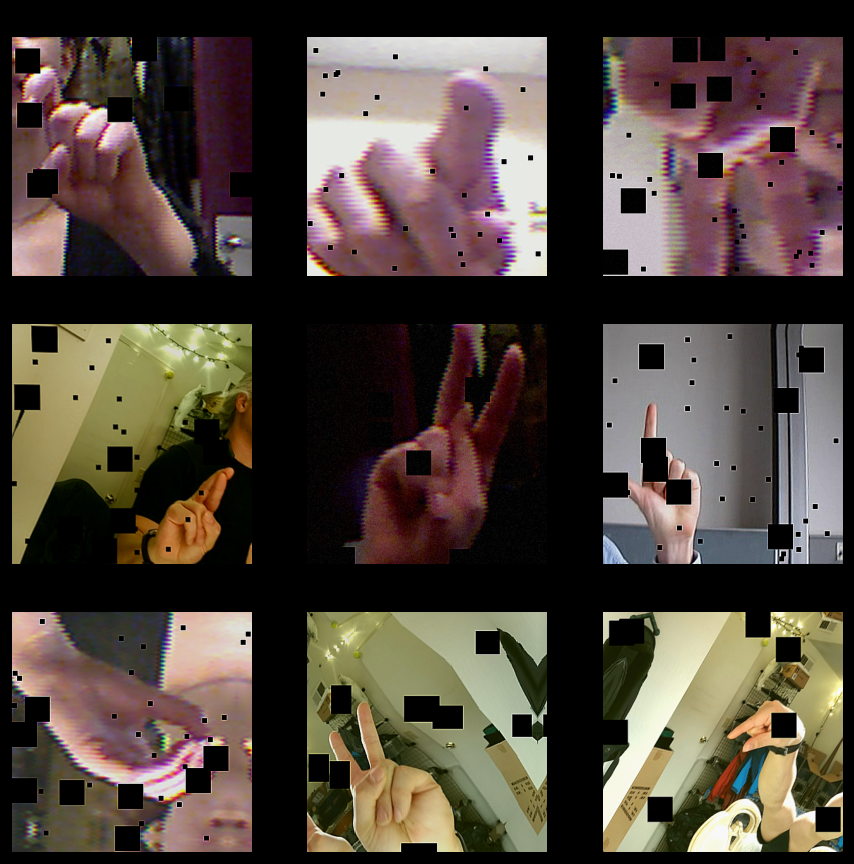

In [15]:
dls.train.show_batch(max_n=9)

<br>
<br>

<br>
<br>
<br>

## Create Callbacks

In [16]:
cutmix_cb = None
mixup_cb = None

def create_callbacks():
    global cutmix_cb, mixup_cb

    # Eary stopping callback
    early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=15, reset_on_fit=True)

    # Save the current model's weights every epoch
    save_cb = SaveModelCallback(fname=RUN_NAME, with_opt=True)

    # Reduce the Learning Rate if valid_loss flatlines
    reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=3, factor=10, reset_on_fit=True)

    # Mixup callback for regularization
    # mixup_cb = MixUp(alpha=0.3)
    mixup_cb = None

    # Cutmix callback for regularization
    cutmix_cb = CutMix()
#     cutmix_cb = None

    # Gradient Accumulation
    # gradacc_cb =  GradientAccumulation(n_acc=16)
    gradacc_cb =  GradientAccumulation(n_acc=128)
  
    # log our runs
    csv_log_cb = CSVLogger(fname=f'CSV-History/{RUN_NAME}.csv', append=True)


    # List of callbacks to be used later
    cbs = [save_cb, ShowGraphCallback(), GradientClip(), early_stop_cb, gradacc_cb]  #, reduceLR_cb, early_stop_cb, csv_log_cb] #, reduceLR_cb]

    if mixup_cb != None:
        cbs.insert(0, mixup_cb)

    if cutmix_cb != None:
        cbs.insert(0, cutmix_cb)

    print('\nAll Callbacks: ', cbs)
    return cbs

# empty
cbs = create_callbacks()


All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, GradientClip, EarlyStoppingCallback, GradientAccumulation]


<br>
<br>

### Visualize the effect of CutMix


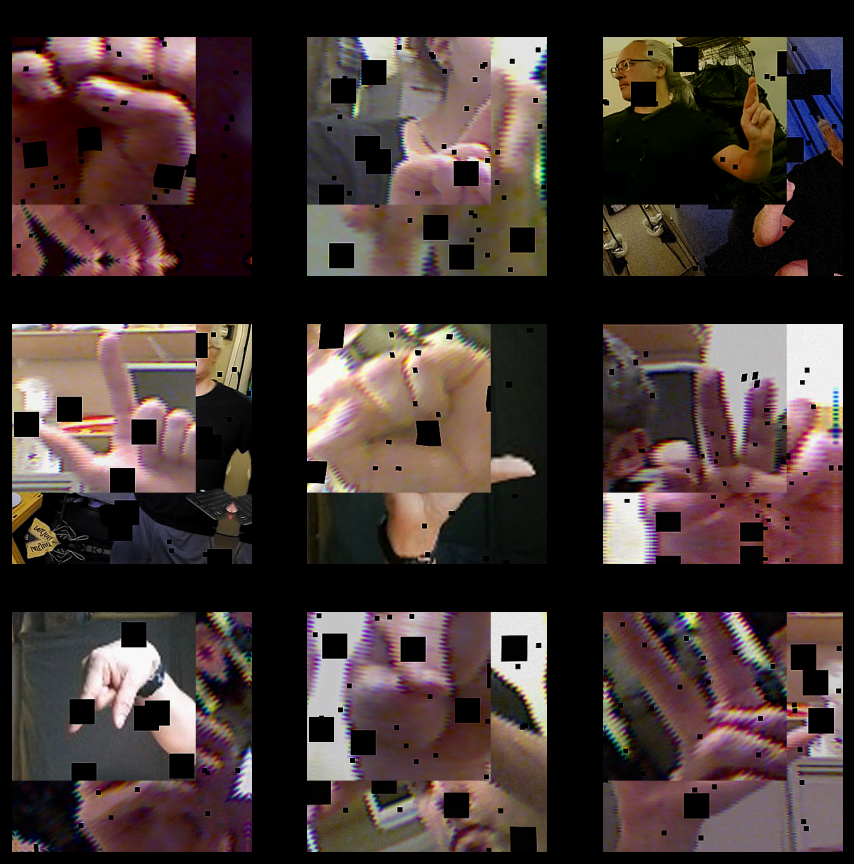

In [17]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')

<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [18]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')


 MixUp was not selected.


<br>
<br>

<br>
<br>

# Model Instantiation

## Define the model and fit

In [19]:
import timm

def create_learner(cat_weights=None):
    # Create the learner
    learn = timm_learner(dls, 
                         ARCH,
                         opt_func=ranger,
                         loss_func=LabelSmoothingCrossEntropyFlat(weight=cat_weights),
#                          loss_func=LabelSmoothingCrossEntropyFlat(),
                          cbs=create_callbacks(), 
                         pretrained=PRETRAINED_FLAG,
                         metrics = [error_rate, accuracy, RocAuc()]
                        )


    # Learner Surgery - replacing modules
    learn.model[0] = convert_seq_chkpt(learn.model[0], nn.Sequential)  # hack in gradient checkpoints for memory savings
#    learn.model[0] = nn.Sequential(CheckpointModule(learn.model[0], 1))  # hack in the final checkpointmodule for the base sequence

    learn = convert_MP_to_blurMP(learn, nn.MaxPool2d)  # replace max pool with with BlurMaxPool
    learn.model[1] = convert_act_cls(learn.model[1], nn.ReLU, MishAuto())  # very expensive so we only use it on the head
    learn.model[0] = convert_act_cls(learn.model[0], nn.ReLU, SwishAuto())  # replace with a lower memory version
    
#    learn = learn.to_fp16()  # convert to mixed precision for memory savings

    learn = learn.to_non_native_fp16()

    return learn


In [20]:
learn = create_learner()


All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, GradientClip, EarlyStoppingCallback, GradientAccumulation]


<br>
<br>

### Look at the Loss Function, Optimization Function and Model Architecture

In [21]:
print('\nLoss Function: ', learn.loss_func)
print('\nOptimization Function: ', learn.opt_func)
print('\n\n', learn.model[1])


Loss Function:  FlattenedLoss of LabelSmoothingCrossEntropy()

Optimization Function:  <function ranger at 0x7fb4080de0d0>


 Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(1792, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1792, out_features=512, bias=False)
  (5): MishAuto()
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=24, bias=False)
)


<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [22]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

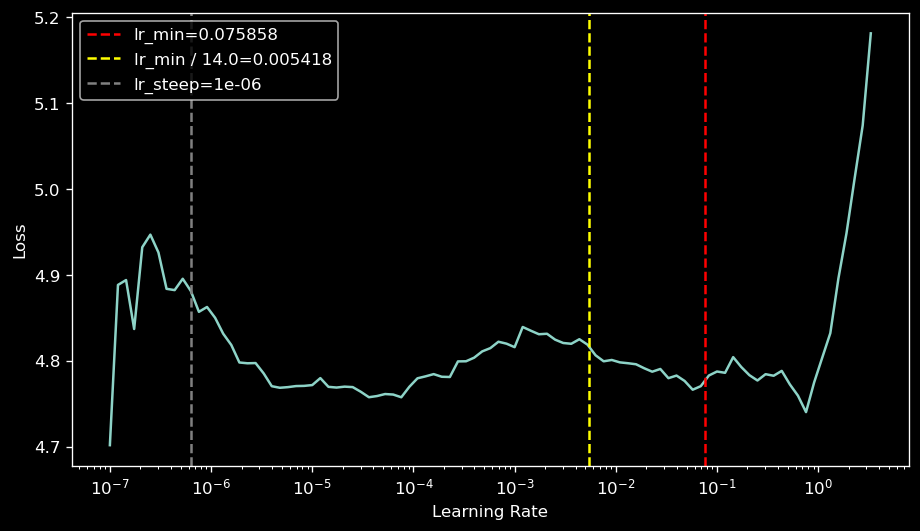

Minimum/10: 7.59e-02, steepest point: 6.31e-07, (Mim/10)/14.0: 0.005418411323002407


In [23]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

<br>
<br>

# Pick a Good Initial Learning Rate

In [24]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
LR_CHOICE = lr_min

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



FROZEN_EPOCHS:  1
EPOCHS:         15
Learning Rate:  0.07585775852203369




Better model found at epoch 0 with valid_loss value: 1.8574225902557373.


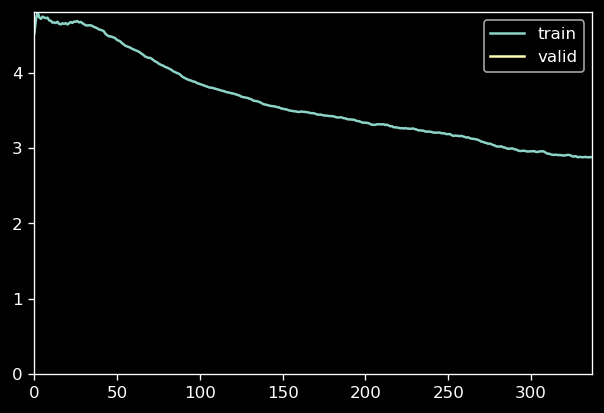

In [25]:


print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

# learn.fine_tune(EPOCHS, freeze_epochs=FROZEN_EPOCHS, base_lr=lr_min/LR_DIV)
#learn.fine_tune(EPOCHS, freeze_epochs=0)
if PRETRAINED_FLAG == True:
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1, reset_opt=True)

# learn.fine_tune(1, base_lr=lr_min/12)

In [26]:
# Persist a Copy

# Need to do this first as it won't pickle
# learn.remove_cbs(CSVLogger)

learn.export(f'models/STAGE1_{RUN_NAME}.pkl')
print(f'Saved to: models/STAGE1_{RUN_NAME}.pkl')

# put the logger back in
# learn.add_cbs(CSVLogger(fname=f'{RUN_NAME}.csv', append=True))

Saved to: models/STAGE1_20210303-1849 - arch=tf_efficientnet_b4_ns - samples=1100 frozen=1 epochs=15 bs=48 res=380 _data=combined2.pkl


## Manually set up the unfrozen runs

In [27]:
learn.unfreeze()

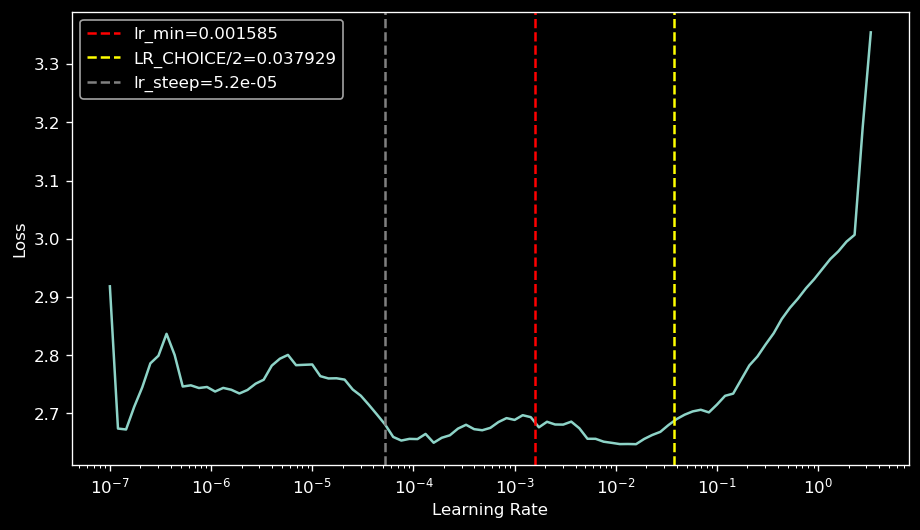

In [28]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.legend()
plt.show()

In [29]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, LR_CHOICE/2: {LR_CHOICE / 2}")

Minimum/10: 1.58e-03, steepest point: 5.25e-05, LR_CHOICE/2: 0.037928879261016846


## Pick a new Learning Rate

In [30]:
# LR_CHOICE_UNFROZ = lr_min/LR_DIV
# LR_CHOICE_UNFROZ = LR_CHOICE / 2
# LR_CHOICE_UNFROZ = 0.00015
LR_CHOICE_UNFROZ = 7e-4
# LR_CHOICE_UNFROZ = 10e-5
# LR_CHOICE_UNFROZ = 0.00008

### Train

In [31]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         15
Learning Rate:  0.0007




Better model found at epoch 0 with valid_loss value: 1.0601636171340942.


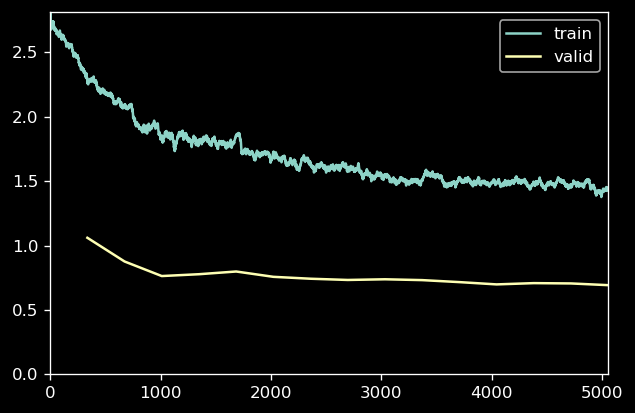

Better model found at epoch 1 with valid_loss value: 0.8760725259780884.
Better model found at epoch 2 with valid_loss value: 0.7630342841148376.
Better model found at epoch 5 with valid_loss value: 0.7570176124572754.
Better model found at epoch 6 with valid_loss value: 0.7422418594360352.
Better model found at epoch 7 with valid_loss value: 0.7327033877372742.
Better model found at epoch 9 with valid_loss value: 0.7314627170562744.
Better model found at epoch 10 with valid_loss value: 0.7159689664840698.
Better model found at epoch 11 with valid_loss value: 0.6982220411300659.
Better model found at epoch 14 with valid_loss value: 0.6922913193702698.
Max GPU Memory Allocated: 3.928260096 GB


In [32]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.2, wd=1e-2, reset_opt=False)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

In [33]:
# learn.fine_tune(1, freeze_epochs=1, base_lr=5e-5, cbs=cbs)

In [34]:
# learn.fit(1, cbs=[mixup_cb, ShowGraphCallback(), early_stop])

<br>
<br>

## Persist the Model

In [38]:

c = _remove_cbs()
learn.export(f'../models/{RUN_NAME}.pkl')
# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [39]:
learn.show_results()

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

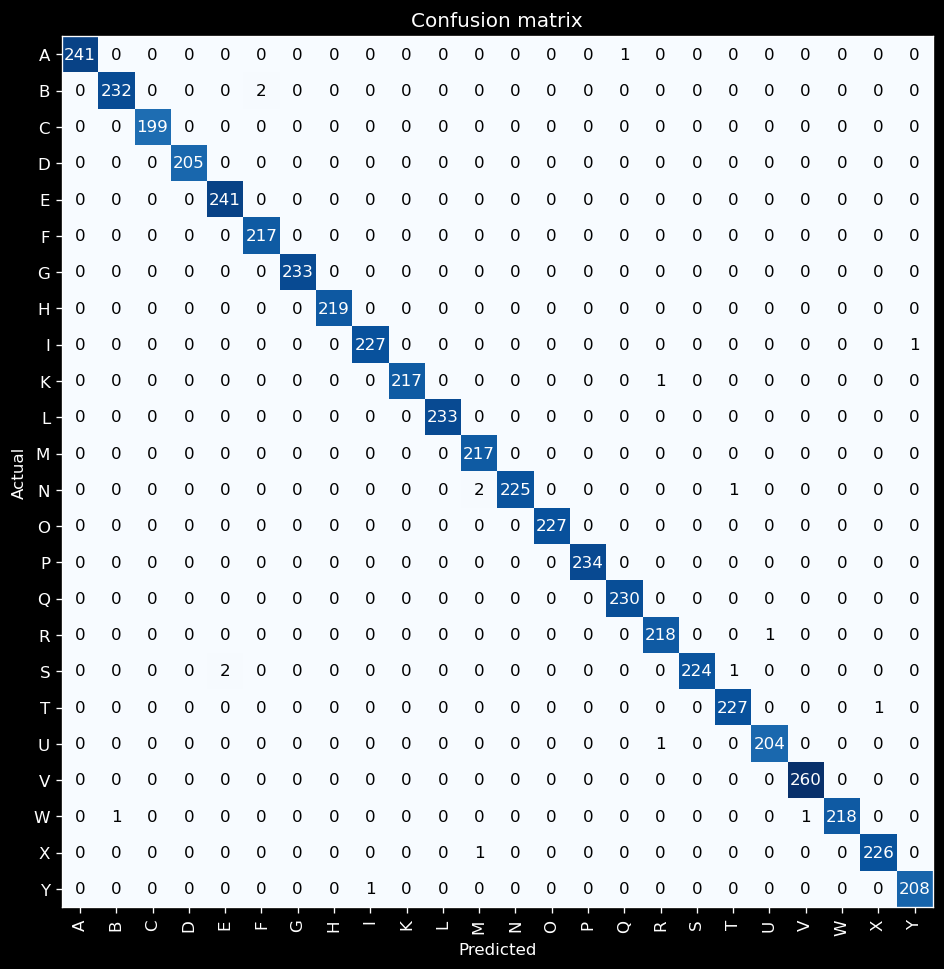

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [41]:
interp.most_confused()[:10]

[('B', 'F', 2),
 ('N', 'M', 2),
 ('S', 'E', 2),
 ('A', 'Q', 1),
 ('I', 'Y', 1),
 ('K', 'R', 1),
 ('N', 'T', 1),
 ('R', 'U', 1),
 ('S', 'T', 1),
 ('T', 'X', 1)]

<br>
<br>

## Classification Report

In [42]:
interp.print_classification_report()

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       242
           B       1.00      0.99      0.99       234
           C       1.00      1.00      1.00       199
           D       1.00      1.00      1.00       205
           E       0.99      1.00      1.00       241
           F       0.99      1.00      1.00       217
           G       1.00      1.00      1.00       233
           H       1.00      1.00      1.00       219
           I       1.00      1.00      1.00       228
           K       1.00      1.00      1.00       218
           L       1.00      1.00      1.00       233
           M       0.99      1.00      0.99       217
           N       1.00      0.99      0.99       228
           O       1.00      1.00      1.00       227
           P       1.00      1.00      1.00       234
           Q       1.00      1.00      1.00       230
           R       0.99      1.00      0.99       219
           S       1.00    

<br>

### Show the top 15 most error prone images

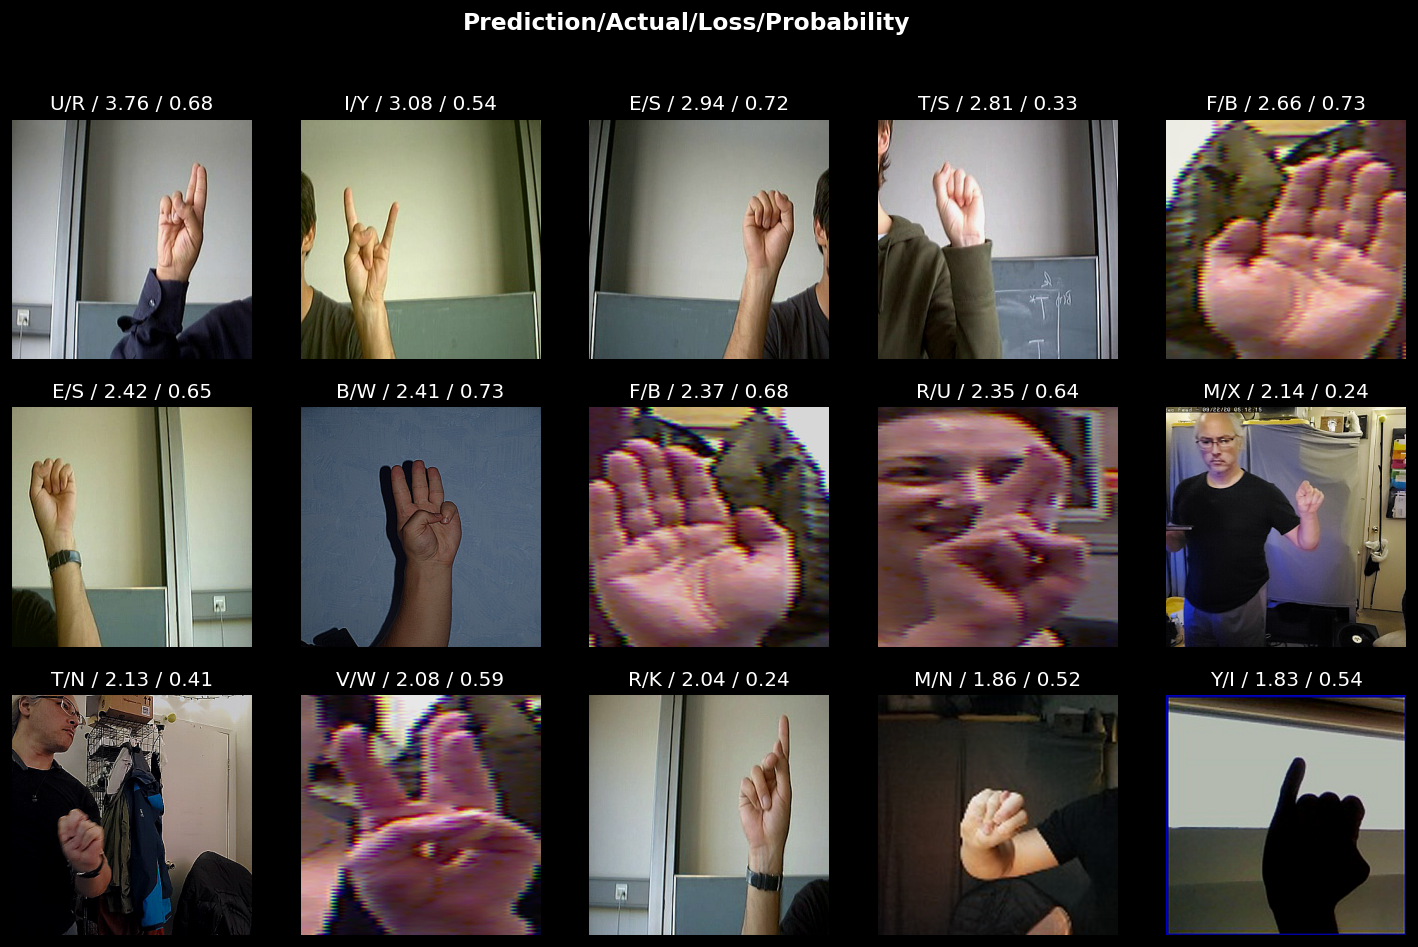

In [43]:
interp.plot_top_losses(15, nrows=3)

<br>
<br>

<br>

### ~~Clean the images that were hard to interpret and obviously bad~~

(I had to remove this section as it was using too much RAM and crashing the kernel)

### Show a Widget that allows us to mark poor exemplars for deletion

In [ ]:
# import gc
# cleaner = None
# gc.collect()

# cleaner = ImageClassifierCleaner(learn)
# cleaner

### Show the Indexes of the images we want to delete

In [ ]:
# cleaner.delete()

### Delete the files

In [ ]:
# import os

# for idx in cleaner.delete():
#     print(f'removing: {str(cleaner.fns[idx])}')
#     os.remove(str(cleaner.fns[idx]))

<br>
<br>
<hr>
<br>
<br>




<br>
<br>

# Test Set Analysis

<br>

In [92]:
# test_learn = learn
# num = 3
# RUN_NAME='20210122-0037 - arch=xresnet50_deep - samples=3000 frozen=1 epochs=40 bs=16 res=360 _data=external'
# RUN_NAME = '20210122-2356 - arch=xresnet50_deep - samples=3000 frozen=1 epochs=40 bs=16 res=360 _data=external'

# test_learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME}_{num}.pth', test_learn, opt=Adam, with_opt=False)



test_learn = learn

In [104]:
def get_test_fnames(path):
    l = [ _l for _ls in list(test_image_files.values()) for _l in _ls]  # flat list
    
    return random.sample(l, len(l))

In [105]:
path

'../data/combined2/Training_Set'

In [106]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=item_tfms, batch_tfms=batch_tfms)
#     item_tfms=Resize(RESOLUTION, method='bilinear')) #,
#     item_tfms=CropPad(RESOLUTION, pad_mode='zeros'))
#    ,    batch_tfms=aug_transforms(do_flip=True, size=RESOLUTION, batch=False, max_zoom=1.0, mult=1, pad_mode='zeros'))

# signs = DataBlock(
#     blocks=(ImageBlock, CategoryBlock), 
#     get_items=get_fnames, 
#     splitter=RandomSplitter(valid_pct=0.25, seed=42),
#     get_y=parent_label,
#     item_tfms=item_tfms, batch_tfms=batch_tfms)

dls = test_db.dataloaders(path, bs=BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

In [107]:
# test_learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
# test_learn = cnn_learner(dls, arch=ARCH, metrics=[error_rate, accuracy], cbs=cbs, loss_func=LabelSmoothingCrossEntropy(), pretrained=PRETRAINED_FLAG)
# RUN_NAME = '20210119-0130 - arch=xresnet50 - samples=1000 frozen=0 epochs=25 bs=20 res=300 _data=external'
# load_model(f'models/{RUN_NAME}_1.pth', test_learn, opt=Adam)


# test_learn = cnn_learner(dls, arch=ARCH, metrics=[error_rate, accuracy], pretrained=PRETRAINED_FLAG)
# test_learn.load(f'{RUN_NAME}_24')

<br>
<br>

####  Get the Inferrences on the Test Set

In [109]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)


In [110]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

In [111]:
# test_learn.get_preds()

<br>

### Visualize with a confusion Matrix

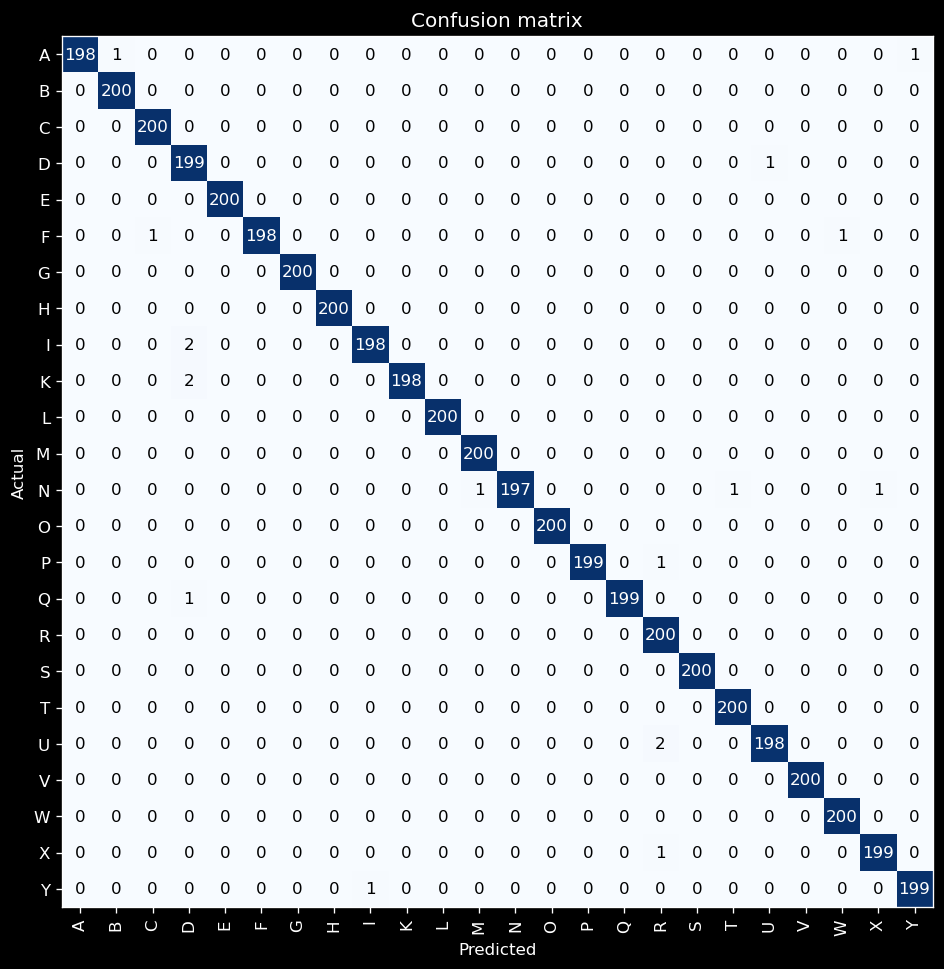

In [112]:
interp.plot_confusion_matrix(figsize=(8,8))

In [113]:
interp.most_confused()[:10]

[('I', 'D', 2),
 ('K', 'D', 2),
 ('U', 'R', 2),
 ('A', 'B', 1),
 ('A', 'Y', 1),
 ('D', 'U', 1),
 ('F', 'C', 1),
 ('F', 'W', 1),
 ('N', 'M', 1),
 ('N', 'T', 1)]

<br>
<br>

## Classification Report

In [114]:
interp.print_classification_report()

              precision    recall  f1-score   support

           A       1.00      0.99      0.99       200
           B       1.00      1.00      1.00       200
           C       1.00      1.00      1.00       200
           D       0.98      0.99      0.99       200
           E       1.00      1.00      1.00       200
           F       1.00      0.99      0.99       200
           G       1.00      1.00      1.00       200
           H       1.00      1.00      1.00       200
           I       0.99      0.99      0.99       200
           K       1.00      0.99      0.99       200
           L       1.00      1.00      1.00       200
           M       1.00      1.00      1.00       200
           N       1.00      0.98      0.99       200
           O       1.00      1.00      1.00       200
           P       1.00      0.99      1.00       200
           Q       1.00      0.99      1.00       200
           R       0.98      1.00      0.99       200
           S       1.00    

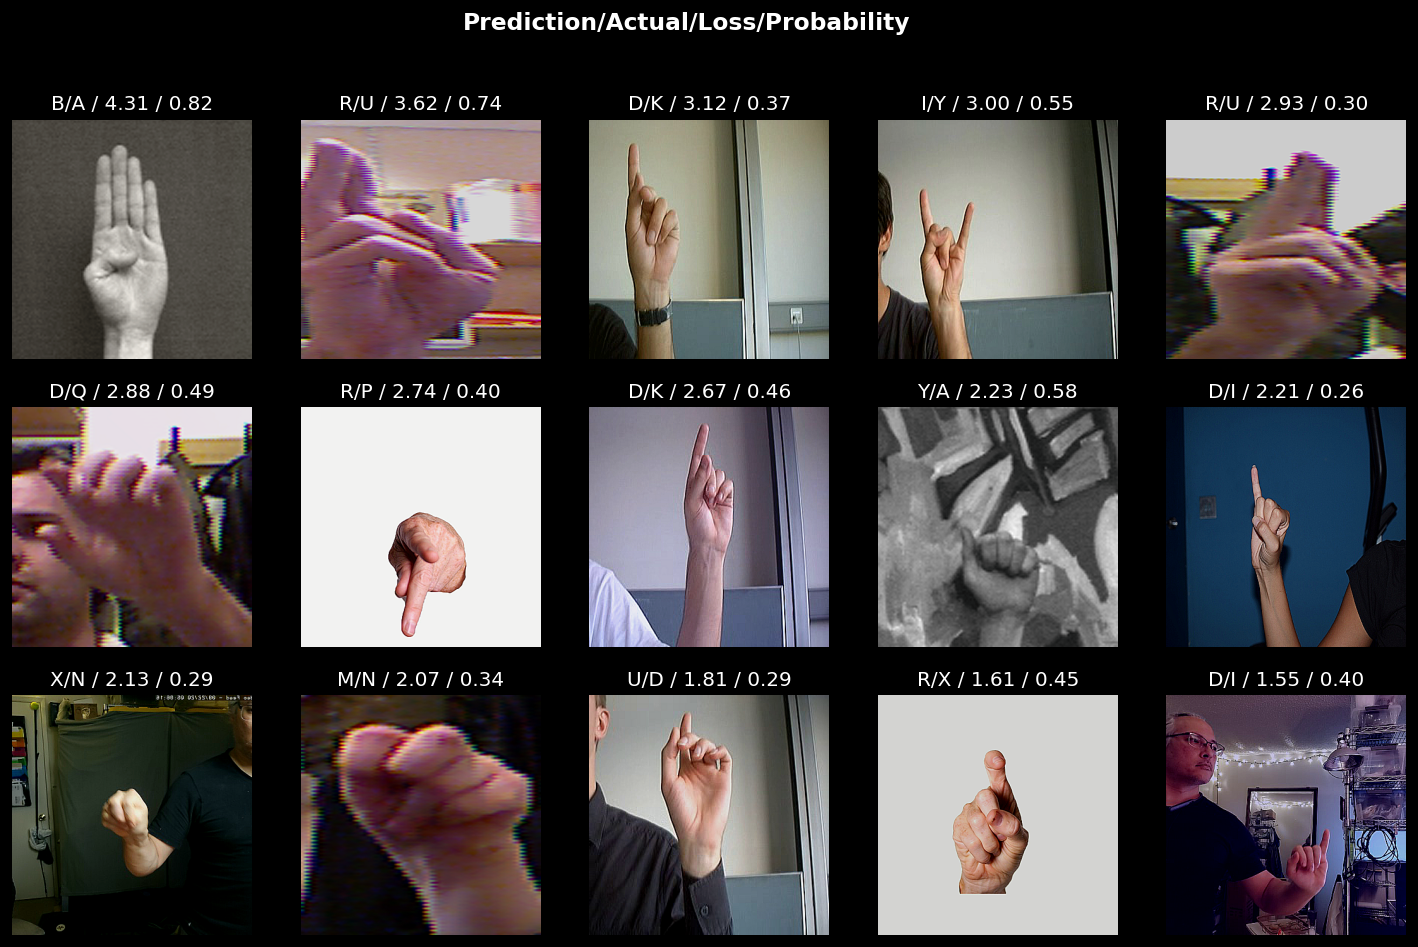

In [115]:
interp.plot_top_losses(k=15)

<br>
<br>
<br>

## Clean up

<br>

In [116]:
wandb.join()

In [117]:
wandb.finish()

<br>
<br>
<br>
<hr>
<br>

# Log

* started to plot the learning rates and started to use that information while fitting.
* Downgraded to resnet34 @ 300px in order to increase the resolution fed to the model from 128px to 300px - this made a major difference.
* Decreased the number of training epochs to 6 after experimenting to find the sweet spot. - also positive change
* Changed to exclusively use fine-tune() with it's built in freeze_epochs parameter
* Changed the Batch Size in order to bring the arch back to resnet101 @300px
* Cleaned up the markdown, removed cells and reordered the rest.
* Added an Early Stop.  Starting with 0.01 delta.  
* Now moving to 0.1 delta
* Integrated wandb to keep track of experiments.
* added section to balance the dataset through oversampling.

** Attempting a batch size of 12 and 384px with resnet101.  long training times.
** Also increased the epochs to 4 on the final layer and 7 on the rest.
    

In [118]:
# learn.unfreeze()

In [119]:
# learn.fine_tune(epochs=2, freeze_epochs=1, base_lr=high)
#                 cbs=[mixup_cb, ShowGraphCallback(), SaveModelCallback(), early_stop])

In [120]:
# low, high = learn.lr_find()

In [121]:
# low

In [122]:
# high

## Archive this version of the notehook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
!sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('Sign4 - EfficientNet.ipynb', f'.Archive/{time} - Sign4 - EfficientNet.ipynb')

In [ ]:
# # learn = cnn_learner(dls, arch=ARCH, metrics=[error_rate, accuracy], cbs=cbs, loss_func=LabelSmoothingCrossEntropy(), pretrained=PRETRAINED_FLAG)
# learn = load_learner('../models/20210118-1443 - arch=resnet50 - samples=480 frozen=0 epochs=6 bs=20 res=300 _data=external.pkl', cpu=False)
# learn.dls = dls

# lr_min,lr_steep = learn.lr_find()
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

# learn.fine_tune(1, freeze_epochs=2, base_lr=lr_min)

In [ ]:
# # image = PILImage.create('../data/20210121_132256.jpg')
# letter = 'F'
# images = [PILImage.create(f'../data/frank/Training_Set/{letter}/1000.jpg'),    PILImage.create(f'../data/frank/Training_Set/{letter}/1008.jpg'),    PILImage.create(f'../data/frank/Training_Set/{letter}/1016.jpg'),    PILImage.create(f'../data/frank/Training_Set/{letter}/1024.jpg'),    PILImage.create(f'../data/frank/Training_Set/{letter}/1032.jpg'),    PILImage.create(f'../data/frank/Training_Set/{letter}/1040.jpg')]

In [ ]:
# for img in images:
#     print(test_learn.predict(img)[0])


In [ ]:
# test_learn.predict(PILImage.create(f'../data/frank/Training_Set/E/1000.jpg'))

In [ ]:
# print(f"RUN_NAME = '{RUN_NAME}'")
